In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import mp_utils as mp

import xgboost as xgb
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../data/data_compressed/df_data.csv')
co = pd.read_csv('../data/data_compressed/df_cohort.csv')
df_static = pd.read_csv('../data/data_compressed/df_static_data.csv')
df_death = pd.read_csv('../data/data_compressed/df_death.csv')
co = co.drop(co.columns[0], axis=1)
df_static = df_static.drop(df_static.columns[0], axis=1)
df_death = df_death.drop(df_death.columns[0], axis=1)

### Baseline model 1.

In [5]:
var_min, var_max, var_first, var_last, var_sum, var_first_early, var_last_early, var_static = mp.vars_of_interest()
sid = np.sort(np.unique(df_death['subject_id'].values))


W = 24
W_extra = 24
y_outcome_label = 'death_in_hospital'

df_tmp=co.copy().set_index('icustay_id')
time_dict = df_tmp.copy()
time_dict['windowtime'] = W
time_dict = time_dict['windowtime'].to_dict()

# Roshomon set

In [6]:
current_study = 'baseline'
exclFcn = lambda x: x.loc[x['inclusion_stay_ge_24hr']& ( (x['censortime_hours'].isnull()) | (x['censortime_hours']>=24) ) ,'icustay_id'].values
    
# Data preparation
df_data = mp.get_design_matrix(df, time_dict, W=W, W_extra=W_extra)
iid_keep = exclFcn(co)
df_data = df_data.reindex(index = iid_keep)
X = df_data.merge(df_static.set_index('icustay_id')[var_static], how='left', left_index=True, right_index=True)
X = X.merge(co.set_index('icustay_id')[[y_outcome_label]], left_index=True, right_index=True)
X = X.merge(co.set_index('icustay_id')[['subject_id']], left_index=True, right_index=True)
idxMap = np.searchsorted(sid, X['subject_id'].values)

# assign k-fold
K = 5
np.random.seed(871)
idxK_sid = np.random.permutation(sid.shape[0])
idxK_sid = np.mod(idxK_sid,K)

idxK = idxK_sid[idxMap]
X.drop('subject_id',axis=1,inplace=True)
X = X.values
y = X[:,-1]
X = X[:,0:-1]

In [35]:
# Model evaluation
mdl_val = list()
results_val = list() # initialize list for scores
pred_val = list()
tar_val = list()

# Hyperparameters tuning
# no pre-processing of data necessary for xgb
model_pipeline = Pipeline([('xgb', xgb.XGBClassifier())])

param_grid = {
        'xgb__max_depth': [1, 3, 6, 8, 10],
        'xgb__learning_rate': [0.001, 0.05, 0.01, 0.1],
        'xgb__subsample': [0.5, 0.7, 0.9, 1.0],
        'xgb__colsample_bytree': [0.4, 0.6, 0.8, 1.0],
        'xgb__colsample_bylevel': [0.5, 0.7, 0.9, 1.0],
        'xgb__min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'xgb__gamma': [0, 0.25, 0.5, 1.0],
        'xgb__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'xgb__n_estimators': [100, 200, 300, 400]}
fit_params = {'xgb__eval_metric': 'logloss'}
estimator = RandomizedSearchCV(model_pipeline, param_grid, cv=5, scoring='roc_auc', n_iter=100)
estimator.fit(X,y,**fit_params)
pd.DataFrame(estimator.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__subsample,param_xgb__reg_lambda,param_xgb__n_estimators,param_xgb__min_child_weight,param_xgb__max_depth,param_xgb__learning_rate,...,param_xgb__colsample_bylevel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.269890,0.899716,0.017159,0.005908,0.5,50,100,1,8,0.01,...,0.7,"{'xgb__subsample': 0.5, 'xgb__reg_lambda': 50....",0.844363,0.856543,0.857798,0.849125,0.852902,0.852146,0.004931,79
1,31.430226,1.836135,0.035320,0.008302,0.7,100,300,1,10,0.05,...,0.9,"{'xgb__subsample': 0.7, 'xgb__reg_lambda': 100...",0.892711,0.901134,0.900189,0.895719,0.899421,0.897835,0.003152,22
2,33.043783,1.915493,0.041865,0.013095,0.5,5,400,3,8,0.001,...,0.9,"{'xgb__subsample': 0.5, 'xgb__reg_lambda': 5.0...",0.858334,0.869828,0.871985,0.862456,0.867936,0.866108,0.005010,69
3,1.331708,0.033801,0.018763,0.002896,0.5,10,100,5,1,0.05,...,0.9,"{'xgb__subsample': 0.5, 'xgb__reg_lambda': 10....",0.836174,0.847036,0.848944,0.845244,0.839175,0.843315,0.004845,80
4,4.230133,0.465815,0.025900,0.006563,1,100,300,5,1,0.01,...,1,"{'xgb__subsample': 1.0, 'xgb__reg_lambda': 100...",0.813148,0.832261,0.826416,0.829326,0.823589,0.824948,0.006571,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,17.808939,0.463988,0.034474,0.006855,1,100,400,5,6,0.1,...,1,"{'xgb__subsample': 1.0, 'xgb__reg_lambda': 100...",0.894124,0.904236,0.902981,0.899577,0.902375,0.900659,0.003606,9
96,3.560798,0.034720,0.027414,0.001957,0.9,0.1,200,1,3,0.001,...,0.5,"{'xgb__subsample': 0.9, 'xgb__reg_lambda': 0.1...",0.836276,0.848427,0.847284,0.837753,0.840228,0.841993,0.004963,83
97,10.731517,0.361155,0.020067,0.000782,1,50,100,5,10,0.01,...,0.7,"{'xgb__subsample': 1.0, 'xgb__reg_lambda': 50....",0.844179,0.858817,0.862472,0.850196,0.858314,0.854796,0.006654,78
98,3.707434,0.025623,0.025185,0.005276,1,5,100,0.5,6,0.01,...,0.7,"{'xgb__subsample': 1.0, 'xgb__reg_lambda': 5.0...",0.861405,0.871860,0.873703,0.864762,0.869681,0.868282,0.004557,64


In [36]:
estimator.best_params_

{'xgb__subsample': 1.0,
 'xgb__reg_lambda': 5.0,
 'xgb__n_estimators': 300,
 'xgb__min_child_weight': 1.0,
 'xgb__max_depth': 10,
 'xgb__learning_rate': 0.05,
 'xgb__gamma': 0.25,
 'xgb__colsample_bytree': 0.6,
 'xgb__colsample_bylevel': 1.0}

In [37]:
estimator_results_df = pd.DataFrame(estimator.cv_results_)
best_index = estimator_results_df.mean_test_score.argmax()
best_point = estimator_results_df.loc[best_index,:]

In [38]:
best_point.mean_test_score

0.9036775078577872

## Number of models in roshomon set for different thetas (from 100 models)

In [42]:
for theta in [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05]:
    print('Number of models in roshomon set for theta ' + str(theta))
    print(len(estimator_results_df[best_point.mean_test_score-estimator_results_df.mean_test_score<=theta]))

Number of models in roshomon set for theta 0.001
2
Number of models in roshomon set for theta 0.0025
8
Number of models in roshomon set for theta 0.005
19
Number of models in roshomon set for theta 0.0075
29
Number of models in roshomon set for theta 0.01
36
Number of models in roshomon set for theta 0.025
52
Number of models in roshomon set for theta 0.05
78


In [81]:
len( estimator_results_df[best_point.mean_test_score-estimator_results_df.mean_test_score<=0.002])

5

In [80]:
roshomon_set = estimator_results_df[best_point.mean_test_score-estimator_results_df.mean_test_score<=0.002]

## 5 best models refit

RandomizedSearchCV discards the actual models it trains on each fold after evaluating them, so we were not able to extract the fitted models from the output. Instead we decided to pick the parameters that performed best (4 best models other than estimator.best_estimator_) on the validation sets and re-train XGBClassifiers with these parameters.

In [7]:
import ast
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt

In [8]:
# best params extraction
cv_results = pd.read_csv('search_results.csv')
best5 = cv_results.sort_values('rank_test_score')[:5]
best5_params = best5['params'].reset_index(drop=True)

In [9]:
best5

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__subsample,param_xgb__reg_lambda,param_xgb__n_estimators,param_xgb__min_child_weight,param_xgb__max_depth,param_xgb__learning_rate,...,param_xgb__colsample_bylevel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
69,31.671736,0.212056,0.035336,0.003750,1.0,5.0,300,1.0,10,0.05,...,1.0,"{'xgb__subsample': 1.0, 'xgb__reg_lambda': 5.0...",0.899245,0.904860,0.907685,0.903692,0.902906,0.903678,0.002746,1
80,16.844840,0.173867,0.038923,0.008042,1.0,50.0,300,0.5,10,0.10,...,0.5,"{'xgb__subsample': 1.0, 'xgb__reg_lambda': 50....",0.898925,0.905476,0.906006,0.900349,0.903138,0.902779,0.002778,2
86,27.500813,0.759097,0.032783,0.004328,0.7,10.0,300,5.0,8,0.05,...,0.9,"{'xgb__subsample': 0.7, 'xgb__reg_lambda': 10....",0.894802,0.904474,0.904771,0.903219,0.903167,0.902087,0.003699,3
88,15.890650,0.523667,0.039338,0.006813,1.0,10.0,400,3.0,8,0.10,...,0.5,"{'xgb__subsample': 1.0, 'xgb__reg_lambda': 10....",0.899258,0.903864,0.904517,0.900468,0.901455,0.901912,0.001997,4
36,29.918422,0.876010,0.045498,0.002694,1.0,100.0,400,1.0,10,0.05,...,0.5,"{'xgb__subsample': 1.0, 'xgb__reg_lambda': 100...",0.896071,0.905172,0.904642,0.900245,0.902716,0.901769,0.003332,5


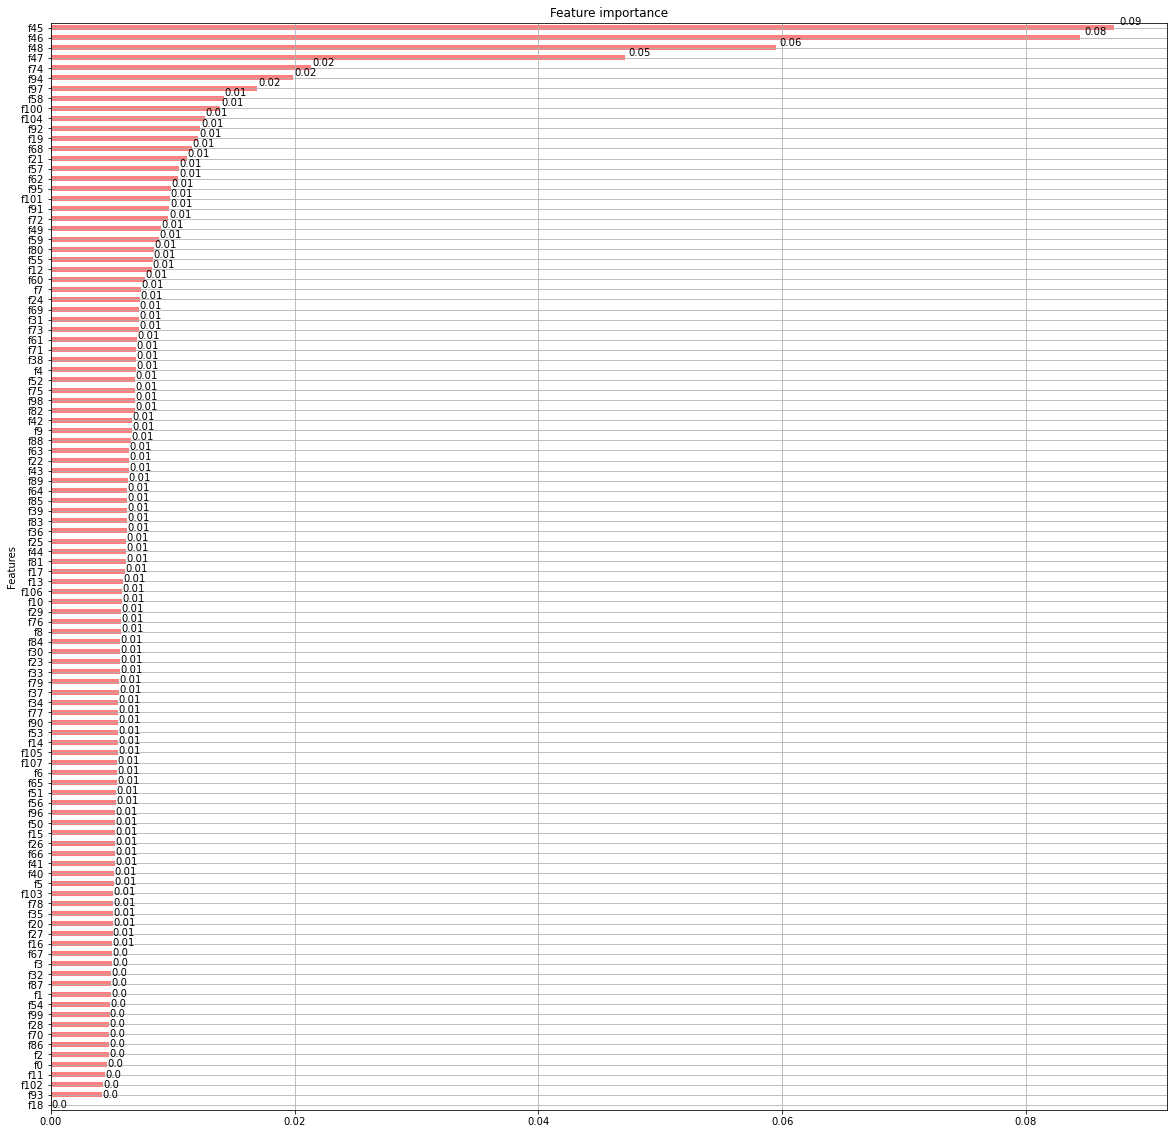

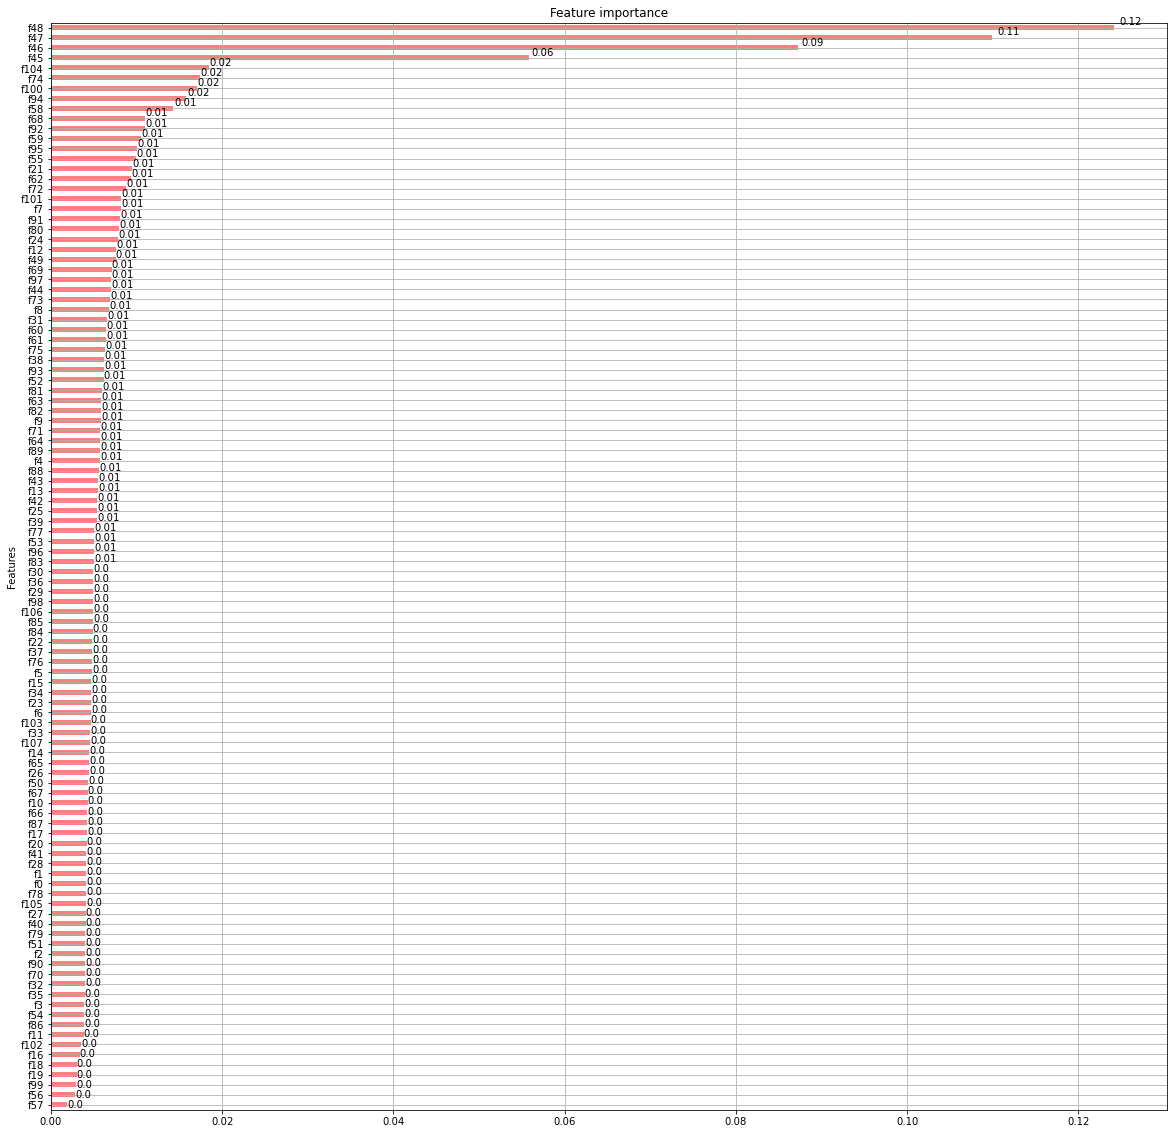

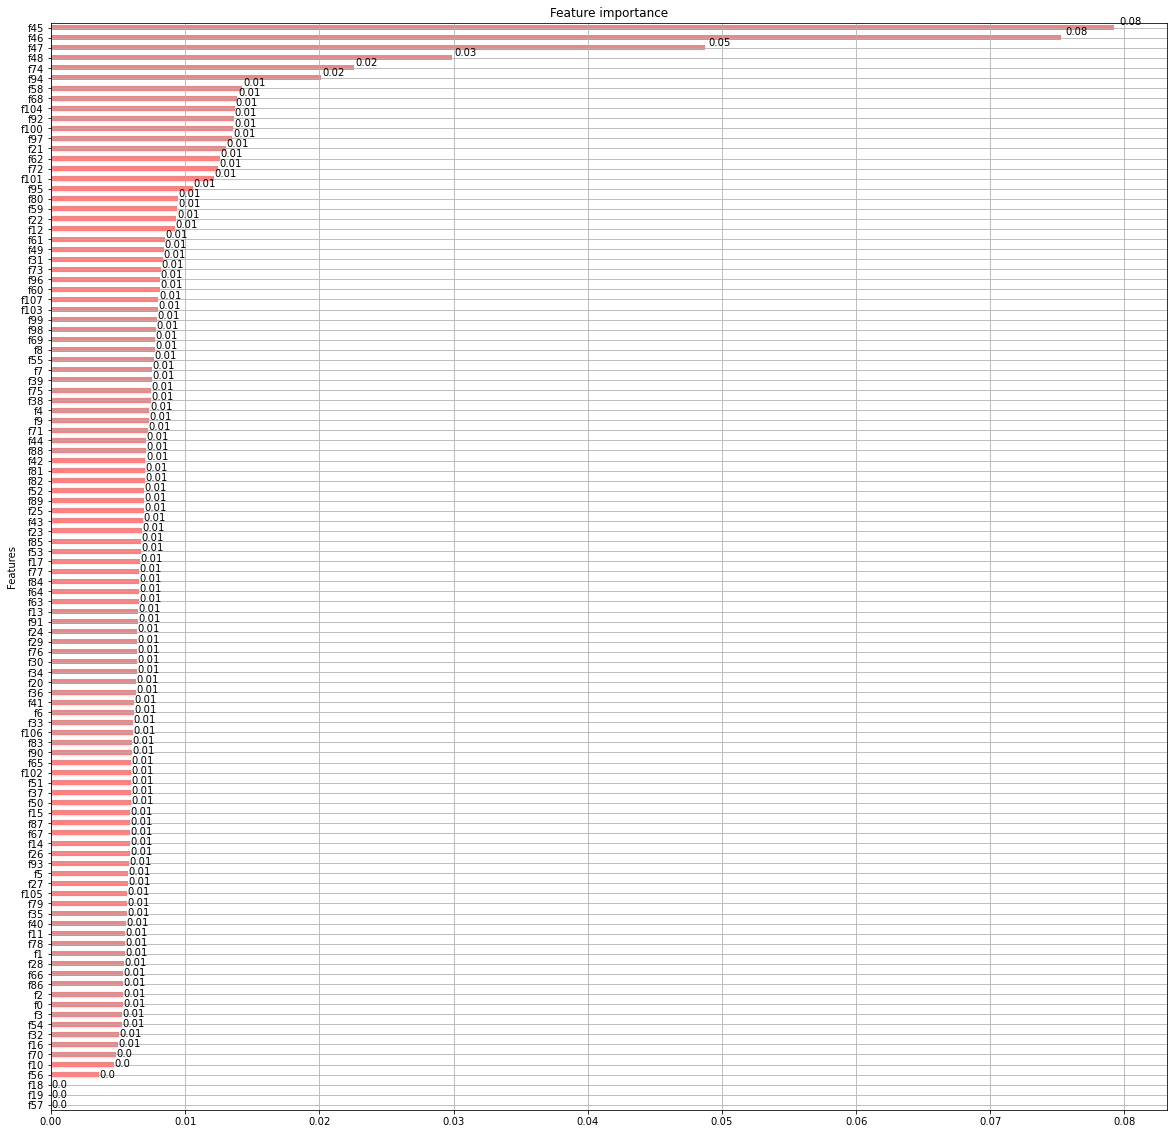

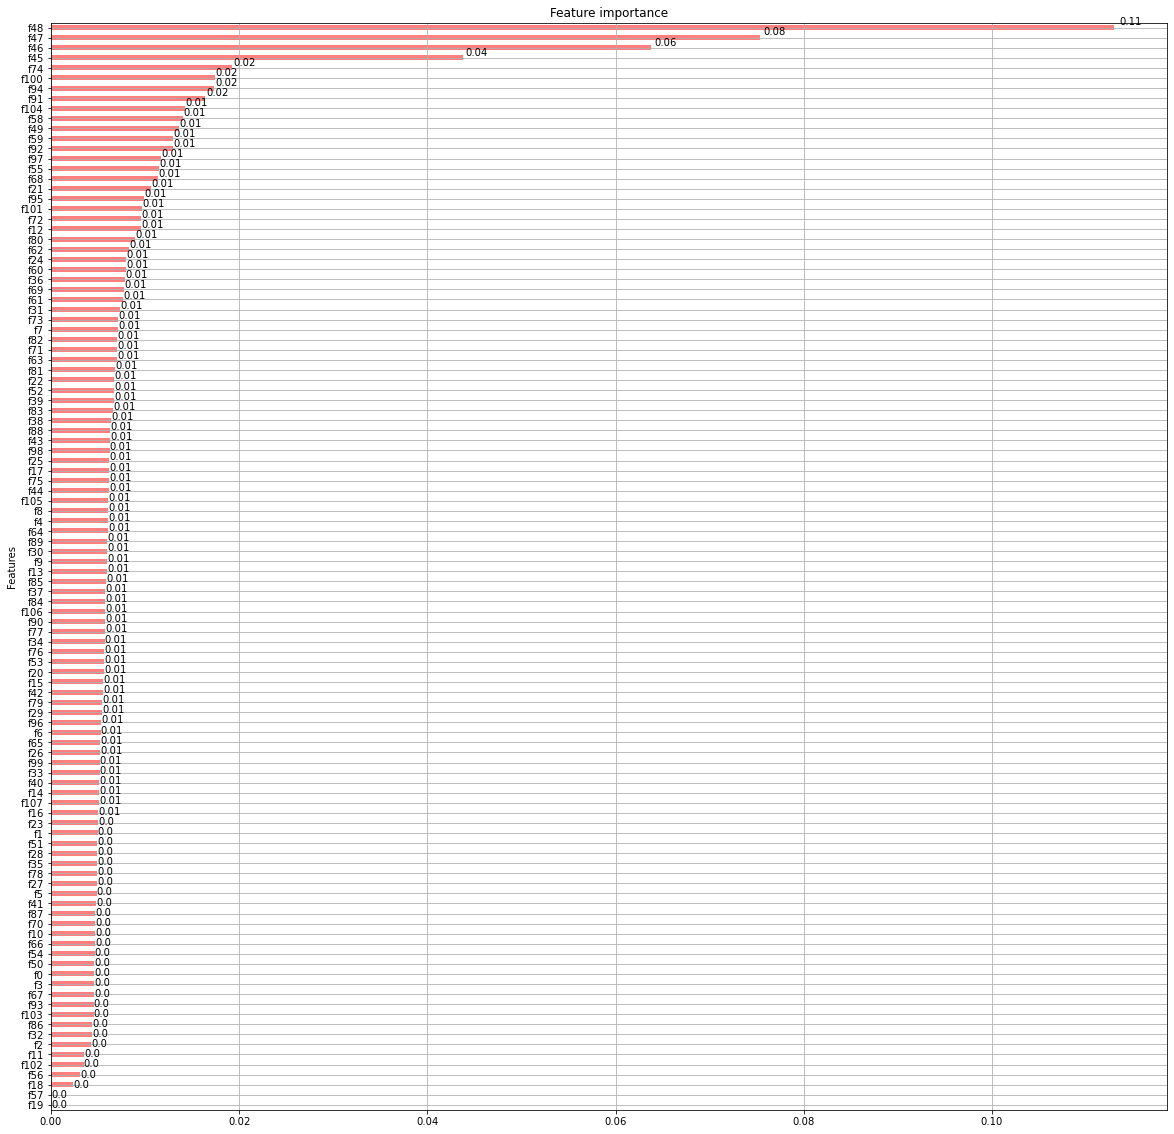

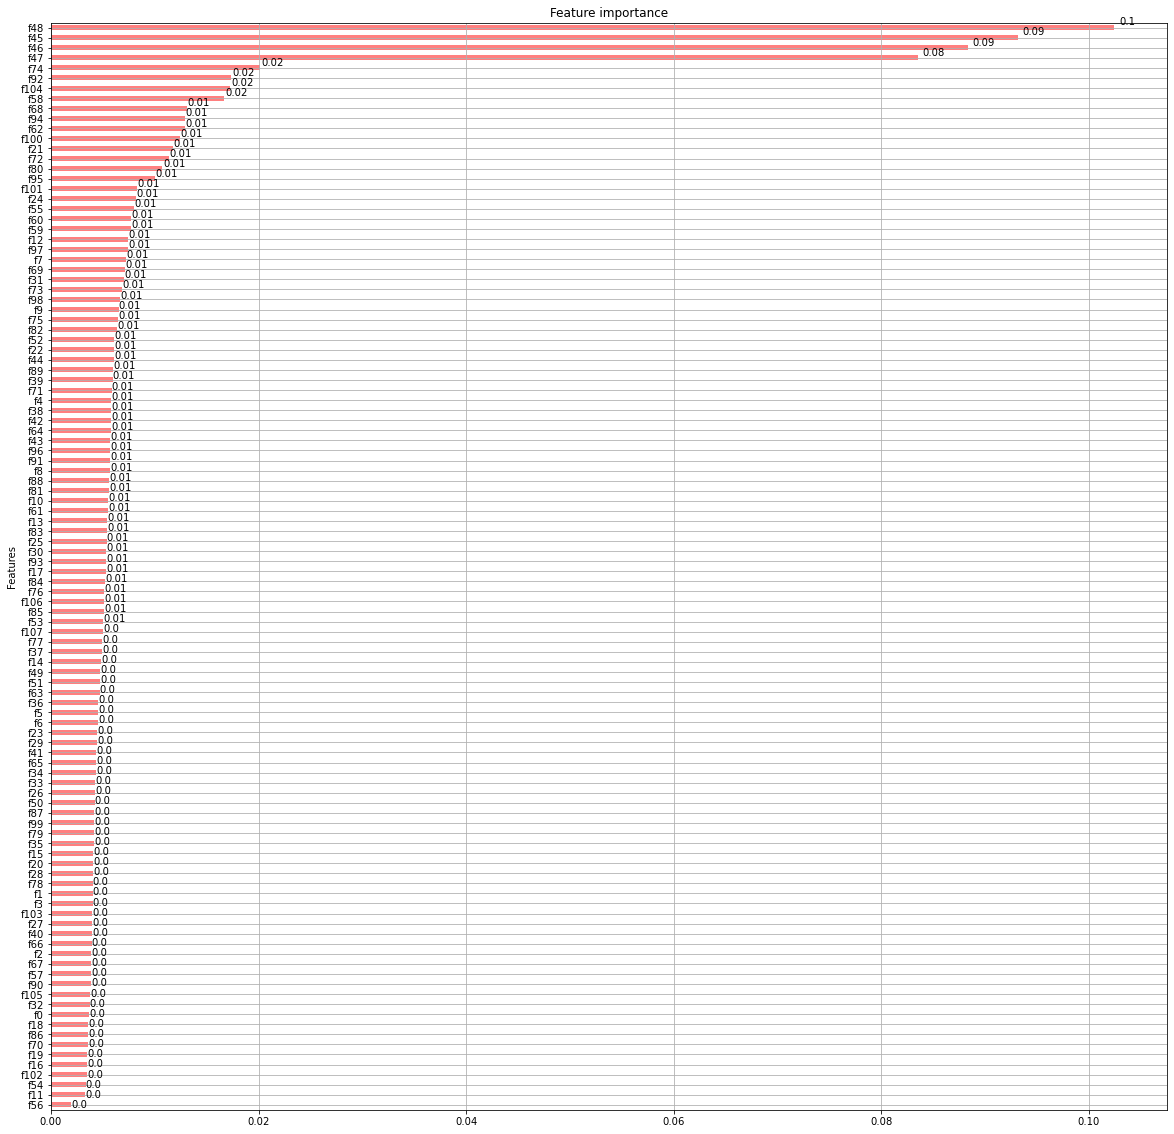

In [10]:
models = []

for params in best5_params:
    # best params preprocessing
    fit_params = {'eval_metric': 'logloss'}
    params = ast.literal_eval(params)
    for k in params.copy():
        params[k[5:]] = params.pop(k)
    # classifiers re-training
    clf = xgb.XGBClassifier()
    clf.set_params(**params)
    clf.fit(X,y,**fit_params)
    models.append(clf)
    # plot_results
    
    
    fs = len(clf.feature_importances_)
    df = pd.DataFrame(zip([f"f{n}" for n in range(fs)], clf.feature_importances_), columns=['Features', 'Feature Importance'])
    df = df.set_index('Features').sort_values('Feature Importance')

    # Build horizontal bar char
    ax = df.plot.barh(color='red', alpha=0.5, grid=True, legend=False, title='Feature importance', figsize=(20, 20))

    for p, value in zip(ax.patches, df['Feature Importance']):
        ax.annotate(round(value, 2), (p.get_width() * 1.005, p.get_y() * 1.005))

    # plot_importance(clf)

### How to compare feature importances?

As comparing rankings is quite tricky, method used to compare the charts should be fitted to the specific problem. For our models, the adequate method  might be to take some top number of variables for each model and see what percent of variables repeats in feature importance of both models. 

## PDP charts

In [11]:
from sklearn.inspection import plot_partial_dependence
from operator import itemgetter

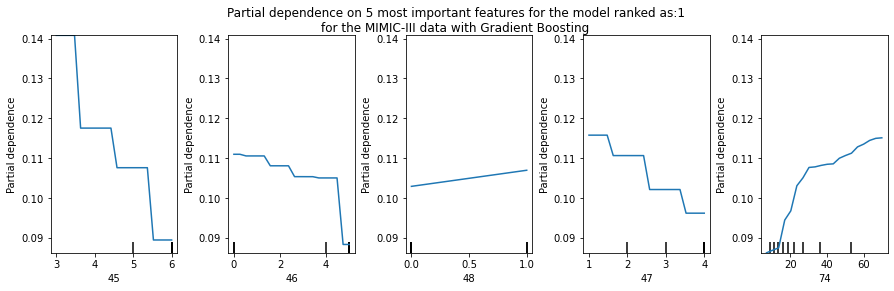

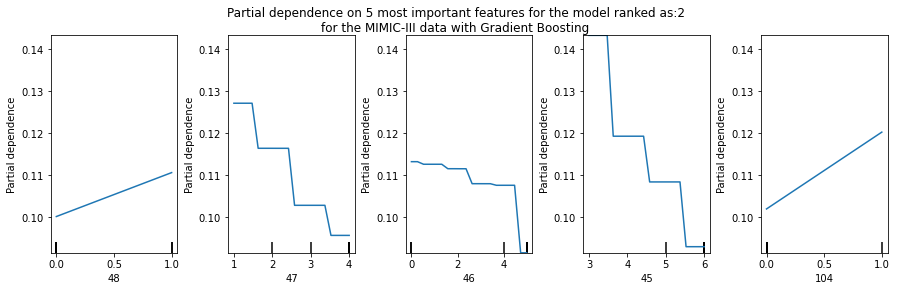

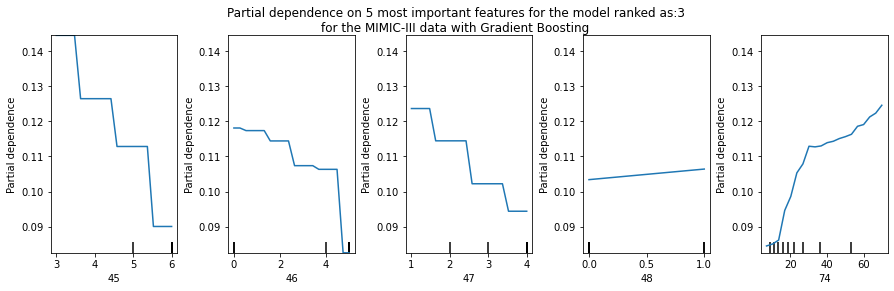

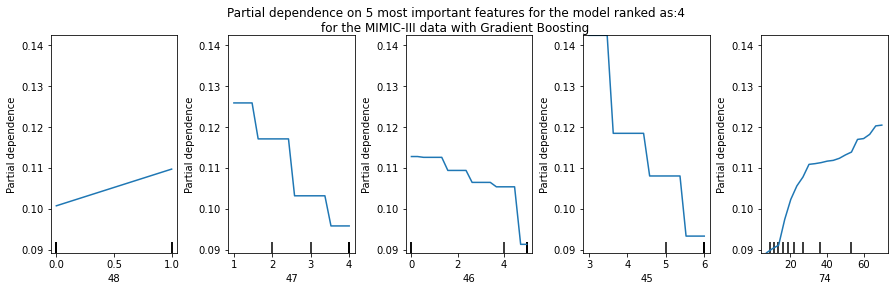

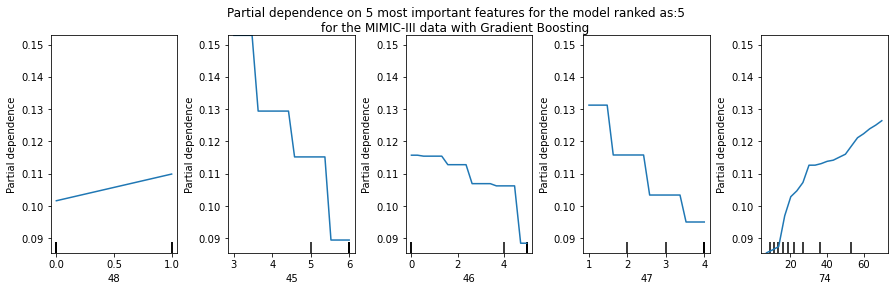

In [12]:
cnt = 0
for model in models:
    cnt += 1
    features = model.feature_importances_.argsort()[::-1][:5]
    _, ax = plt.subplots(ncols=5, figsize=(15, 4))
    display = plot_partial_dependence(model, X, features, n_jobs=3, grid_resolution=20, ax=ax)
    display.figure_.suptitle(
        'Partial dependence on 5 most important features for the model ranked as:' + str(cnt) +  '\n'
        'for the MIMIC-III data with Gradient Boosting'
    )
    display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

### How the PDP charts differ?

It is hard to compare these charst other than by analysing them by eye. Here we can see that for example the PDP chart for variable 45 looks more or less the same for each model. However for variable 46, although the shape of the curve is quite similar, the maximum value achieved differs for each of the model. In conclusion as the PDP curves are very similar for each model, it might not be the best solution for analysing the Roshomon sets. 

## Mean test score depending on parameters values

In [21]:
import seaborn as sns

In [22]:
%matplotlib inline
#plt.rcParams['figure.figsize'] = (10,10)
sns.set_theme(style="whitegrid")

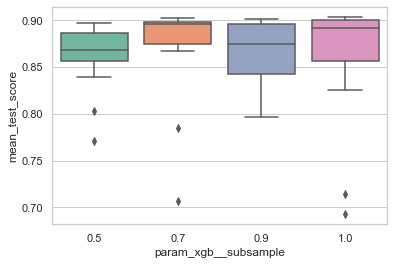

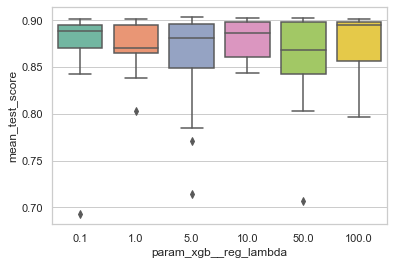

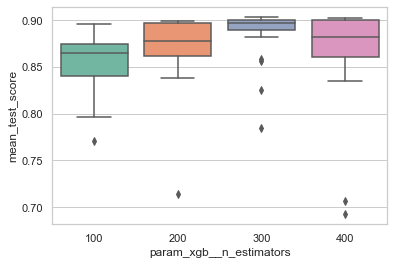

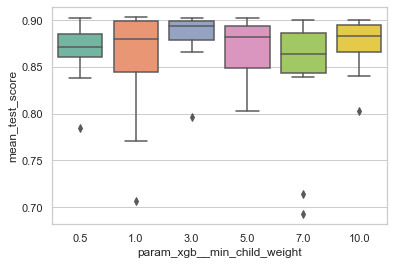

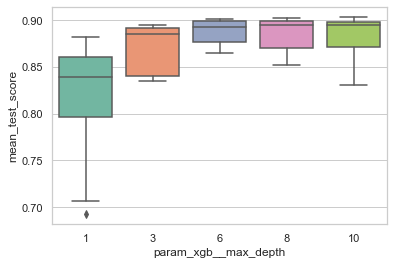

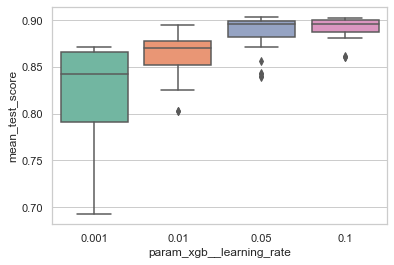

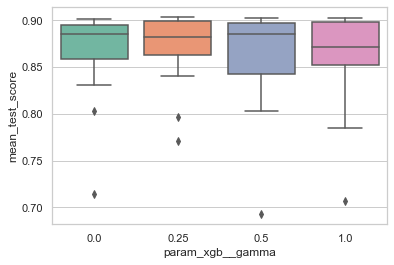

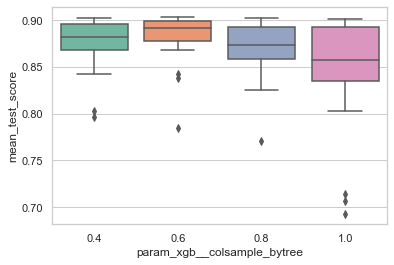

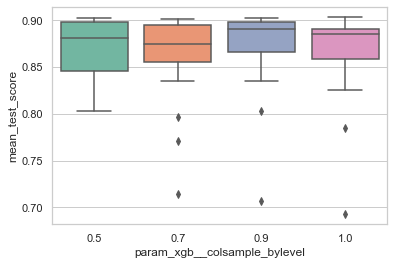

In [23]:
for param in cv_results.columns[4:13]:
    sns.boxplot(x=param, y="mean_test_score", data=cv_results, palette="Set2")
    plt.show()